In [5]:
from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

Skapa en connection med databasen AdventureWorks2022

In [6]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [7]:
engine = new_engine('mssql', 'DESKTOP-ONKVLR4', 'AdventureWorks2022', integrated_security=True)

mssql://DESKTOP-ONKVLR4/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [8]:
connection = engine.connect()

Data som ska komma från SQL

In [19]:
#Antal anställda
# 290 Anställda

amount_of_employees = 'SELECT COUNT(*) AS amount_of_employees FROM HumanResources.Employee'

df = pd.read_sql(sql=amount_of_employees, con=connection)

In [21]:
df.head()

,amount_of_employees
0,290


In [486]:
#Different job titles and how many that work as it
job_titles = '''
SELECT 
    JobTitle,
    COUNT(*) AS workers
FROM 
    HumanResources.Employee
GROUP BY 
    JobTitle
ORDER BY
    workers DESC
'''
df = pd.read_sql(sql=job_titles, con=connection)

In [487]:
df.head()

,JobTitle,workers
0,Production Technician - WC50,26
1,Production Technician - WC60,26
2,Production Technician - WC40,26
3,Production Technician - WC30,25
4,Production Technician - WC20,22


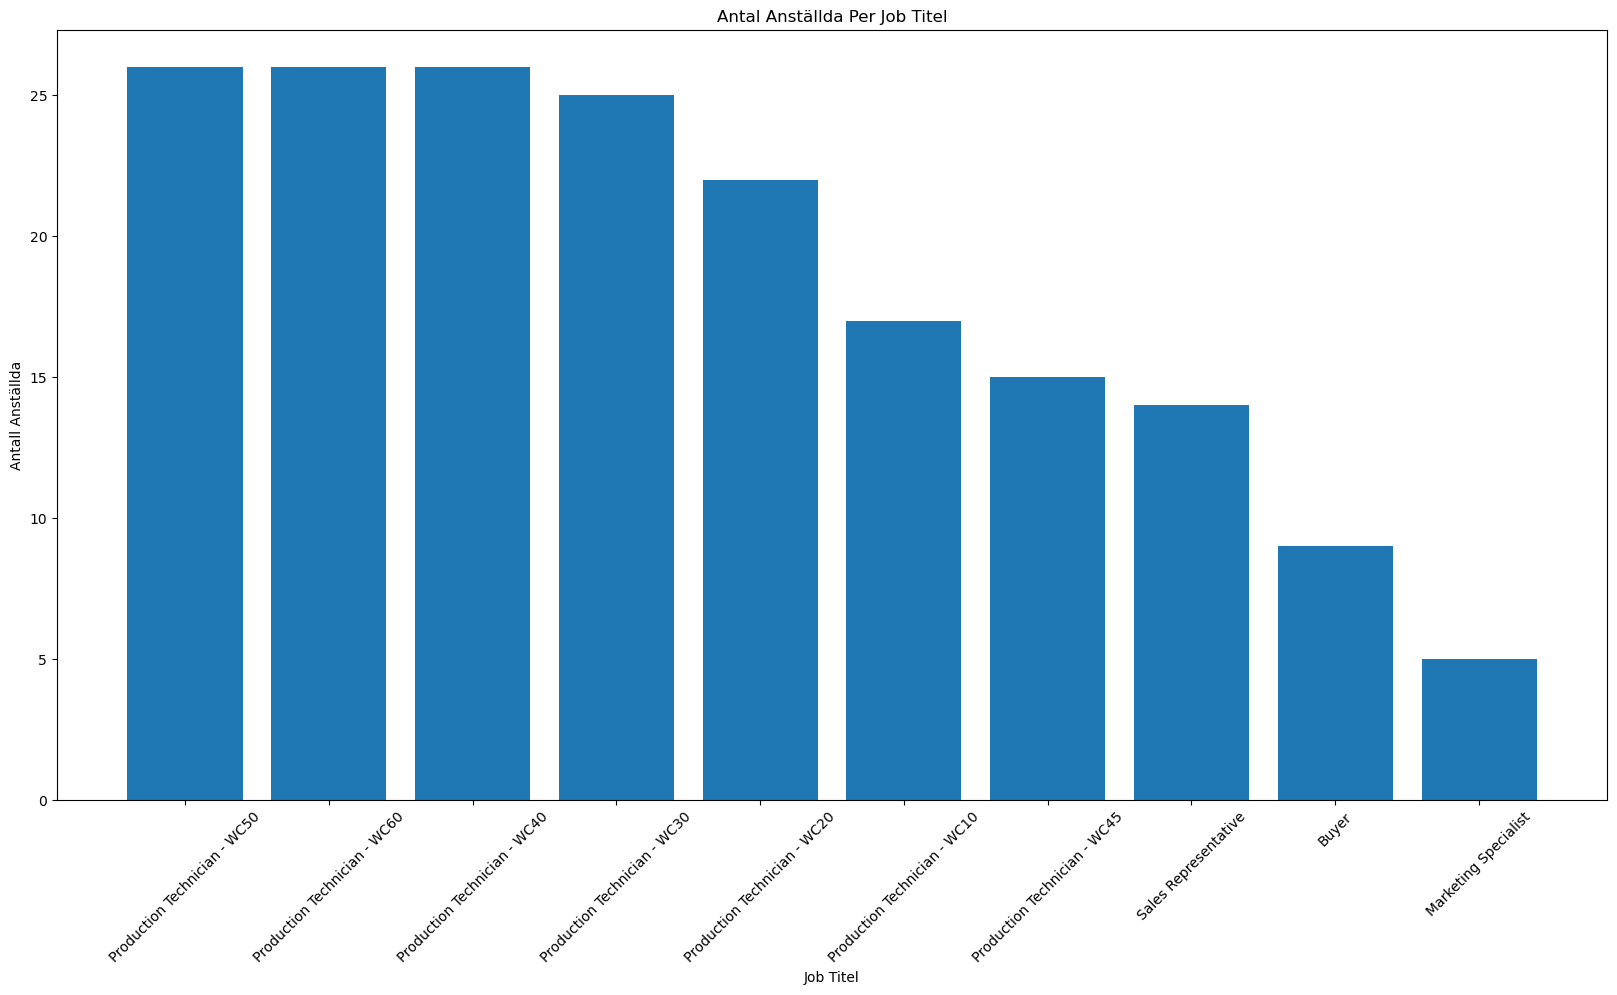

In [490]:
#StapelDiagram 
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 10))

# Plot some data on the axis
x = df['JobTitle'][0:10]
y = df['workers'][0:10]
ax.bar(x, y)


# Set the title and axis labels
ax.set_title('Antal Anställda Per Job Titel')
ax.set_xlabel('Job Titel')
ax.set_ylabel('Antall Anställda')

# Show the plot
plt.xticks(rotation=45)

plt.show()

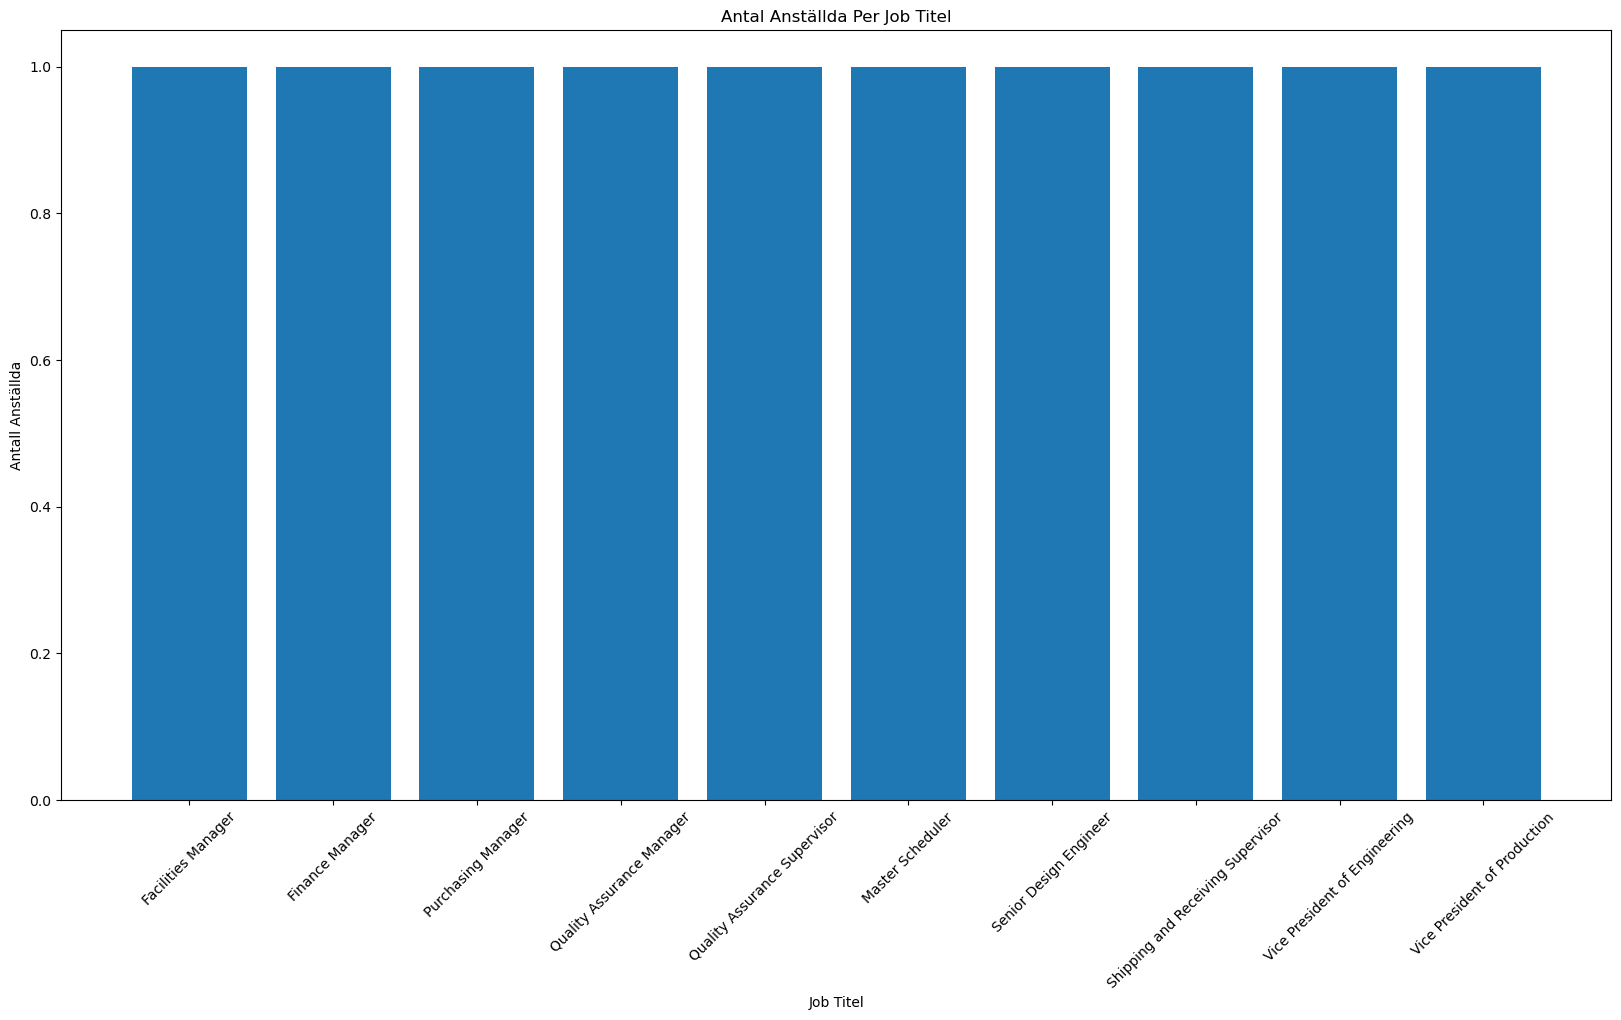

In [492]:
fig, ax = plt.subplots(figsize=(20, 10))
a = df['JobTitle'][-11:-1]
b = df['workers'][-11:-1]
ax.bar(a, b)

# Set the title and axis labels
ax.set_title('Antal Anställda Per Job Titel')
ax.set_xlabel('Job Titel')
ax.set_ylabel('Antall Anställda')

# Show the plot
plt.xticks(rotation=45)

plt.show()

In [9]:
# Gender percentage
# 84 kvinnor (29%), 206 Män(71%), 
gender_percentage = '''
SELECT 
    Gender,
    COUNT(*) AS number_of_gender,
    ROUND(
        (COUNT(*) * 100.0 / (
            SELECT 
                COUNT(*) 
            FROM 
                HumanResources.Employee)
        ), 0) AS gender_percentage
FROM 
    HumanResources.Employee
GROUP BY 
    Gender
'''
df = pd.read_sql(sql=gender_percentage, con=connection)

In [10]:
df.head()

,Gender,number_of_gender,gender_percentage
0,F,84,29.0
1,M,206,71.0


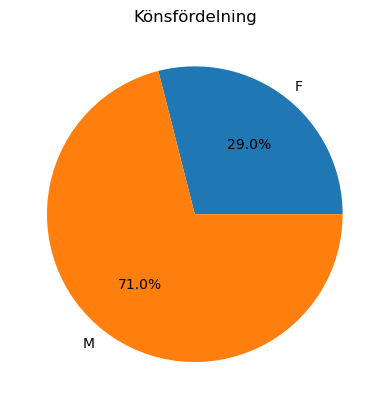

In [11]:
#stapeldiagram
#StapelDiagram 
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot some data on the axis
x = df['Gender']
y = df['number_of_gender']
ax.pie(y, labels=x, autopct='%1.1f%%')

# Set the title and axis labels
ax.set_title('Könsfördelning')

# Show the plot
plt.show()

In [496]:
#Lönetabell
pay = '''
SELECT 
	A.BusinessEntityID,
	Rate,
	JobTitle,
	Gender,
	HireDate,
	BirthDate
FROM
	HumanResources.EmployeePayHistory A
INNER JOIN 
	HumanResources.Employee B
ON
	A.BusinessEntityID = B.BusinessEntityID
ORDER BY
	Rate DESC'''
df = pd.read_sql(sql=pay, con=connection)

In [497]:
df.head()

,BusinessEntityID,Rate,JobTitle,Gender,HireDate,BirthDate
0,1,125.5000,Chief Executive Officer,M,2009-01-14,1969-01-29
1,25,84.1346,Vice President of Production,M,2009-02-03,1983-01-07
2,273,72.1154,Vice President of Sales,M,2011-02-15,1977-06-06
3,2,63.4615,Vice President of Engineering,F,2008-01-31,1971-08-01
4,234,60.0962,Chief Financial Officer,F,2009-01-31,1976-01-06


In [13]:
#avg pay rate between men and women
pay_men_women = '''
SELECT 
	Gender,
	AVG(Rate) AS Average_Rate
FROM
	HumanResources.EmployeePayHistory A
INNER JOIN 
	HumanResources.Employee B
ON
	A.BusinessEntityID = B.BusinessEntityID
GROUP BY 
	Gender'''
df = pd.read_sql(sql=pay_men_women, con=connection)

In [14]:
df.head()

,Gender,Average_Rate
0,F,19.7182
1,M,17.0025


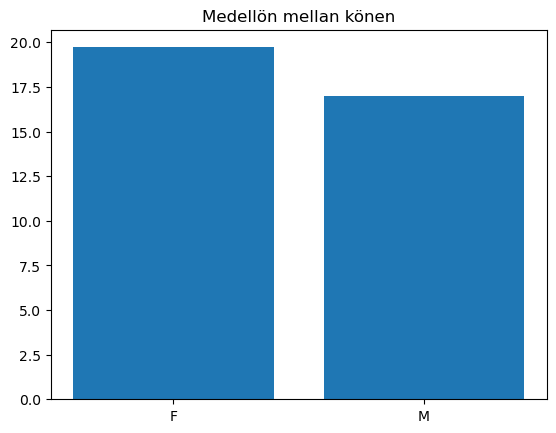

In [15]:
fig, ax = plt.subplots()

# Plot some data on the axis
x = df['Gender']
y = df['Average_Rate']
ax.bar(x, y)

# Set the title and axis labels
ax.set_title('Medellön mellan könen')

# Show the plot
plt.show()

In [501]:
#  Time worked for the company
time_worked_for_company = '''
SELECT 
    BusinessEntityID,
    HireDate,
    CAST(GETDATE() AS DATE) AS [current_date],
    ROUND(
        DATEDIFF(DAY, HireDate, 
            CAST(GETDATE() AS DATE))/ 365.0, 2
          ) AS years_working_for_company,
    (SELECT 
        AVG(ROUND(DATEDIFF(DAY, HireDate, 
            CAST(GETDATE() AS DATE)) / 365.0, 2)
            ) 
    FROM 
        HumanResources.Employee) AS avg_years_spent_for_employees
FROM 
    HumanResources.Employee
GROUP BY 
    BusinessEntityID, 
    HireDate
ORDER BY 
    years_working_for_company DESC
'''
df = pd.read_sql(sql=time_worked_for_company, con=connection)

In [502]:
df.head()

,BusinessEntityID,HireDate,current_date,years_working_for_company,avg_years_spent_for_employees
0,28,2006-06-30,2024-01-01,17.52,14.629344
1,17,2007-01-26,2024-01-01,16.94,14.629344
2,3,2007-11-11,2024-01-01,16.15,14.629344
3,4,2007-12-05,2024-01-01,16.08,14.629344
4,12,2007-12-11,2024-01-01,16.07,14.629344


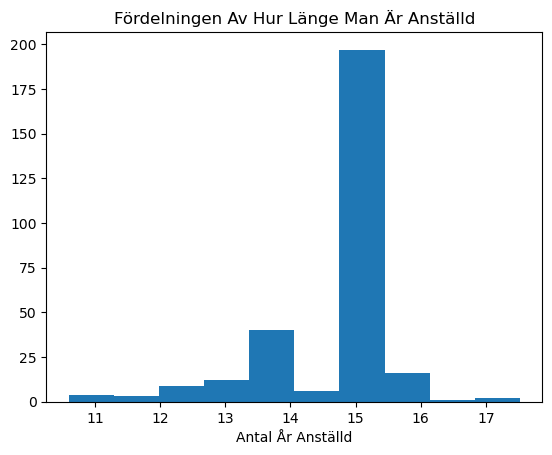

In [504]:
#stapeldiagram med linje som på avg
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot some data on the axis
y = df['years_working_for_company']
ax.hist(y)

#ax.axhline(df['avg_years_spent_for_employees'][0], color='red', linewidth=0.5)


# Set the title and axis labels
ax.set_title('Fördelningen Av Hur Länge Man Är Anställd')
ax.set_xlabel('Antal År Anställd')
ax.set_ylabel('')

# Show the plot
plt.show()

In [505]:
#Time sick
sick_time = '''
--Sick more than vacation

SELECT 
    AVG(SickLeaveHours) AS Avreage_sick_leave,
    AVG(VacationHours)	AS Avergage_Vacation_leave,
    MAX(SickLeaveHours) AS Max_sick_leave,
    MAX(VacationHours) AS Max_vacation_leave,
    MIN(SickLeaveHours) AS Min_sick_leave,
    MIN(VacationHours) AS Min_vacation_leave
FROM 
    HumanResources.Employee
'''
df = pd.read_sql(sql=sick_time, con=connection)

In [506]:
df.head()

,Avreage_sick_leave,Avergage_Vacation_leave,Max_sick_leave,Max_vacation_leave,Min_sick_leave,Min_vacation_leave
0,45,50,80,99,20,0


In [507]:
#Behövs ingen

In [508]:
#Amount more sick than on vacation
#290 anställda
sick_vs_leave = '''
SELECT 
    COUNT(*) AS People_more_sick_than_on_vacation
FROM 
    HumanResources.Employee
WHERE 
    SickLeaveHours > VacationHours'''
df = pd.read_sql(sql=sick_vs_leave, con=connection)

In [509]:
df.head()

,People_more_sick_than_on_vacation
0,107


In [510]:
##Åldersskillnad
age_diff = '''
SELECT 
    AVG(DATEDIFF(YEAR, BirthDate, 
        CAST(GETDATE() AS DATE))) AS Avg_Age,
	MAX(DATEDIFF(YEAR, BirthDate, 
        CAST(GETDATE() AS DATE))) AS Max_Age,
	MIN(DATEDIFF(YEAR, BirthDate, 
        CAST(GETDATE() AS DATE))) AS Min_Age
FROM HumanResources.Employee
'''
df = pd.read_sql(sql=age_diff, con=connection)

In [511]:
df.head()

,Avg_Age,Max_Age,Min_Age
0,45,73,33


In [512]:
##Avdelning
department = '''
SELECT 
	COUNT(*) AS Workers,
	B.Name
FROM
	HumanResources.EmployeeDepartmentHistory A
INNER JOIN 
	HumanResources.Department B
	ON A.DepartmentID = B.DepartmentID
GROUP BY
	B.Name
ORDER BY
	Workers DESC
'''
df = pd.read_sql(sql=department, con=connection)

In [513]:
df.head()

,Workers,Name
0,180,Production
1,18,Sales
2,13,Purchasing
3,11,Finance
4,10,Information Services


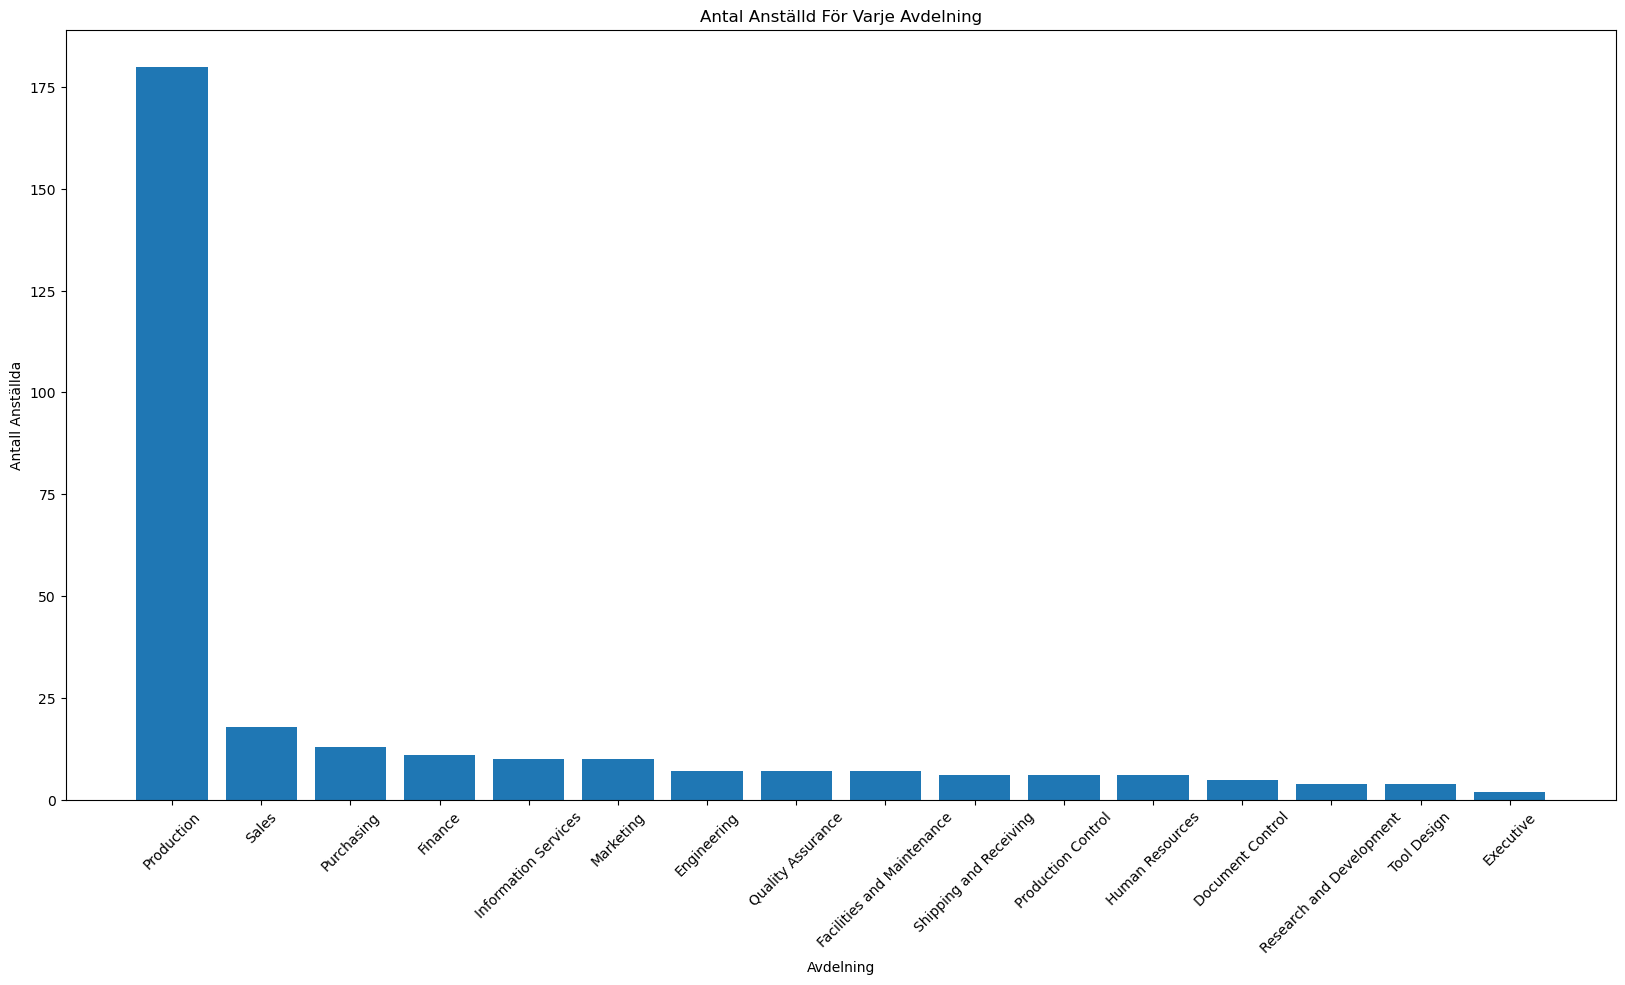

In [515]:
#Diagram
#StapelDiagram 
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20,10))

# Plot some data on the axis
x = df['Name']
y = df['Workers']
ax.bar(x, y)

# Set the title and axis labels
ax.set_title('Antal Anställd För Varje Avdelning')
ax.set_xlabel('Avdelning')
ax.set_ylabel('Antall Anställda')

# Show the plot
plt.xticks(rotation=45)

plt.show()

In [516]:
##Vart jobbar folk från
country = '''
SELECT 
    D.Name,
    D.CountryRegionCode,
    COUNT(*) AS nbr_of_employees_in_state
FROM 
    Person.BusinessEntityAddress AS B
INNER JOIN 
    HumanResources.Employee AS A 
    ON A.BusinessEntityID = B.BusinessEntityID
INNER JOIN 
    Person.Address C
    ON C.AddressID = B.AddressID
INNER JOIN 
    Person.StateProvince D
    ON C.StateProvinceID = D.StateProvinceID
GROUP BY 
    D.Name, D.CountryRegionCode
ORDER BY 
    nbr_of_employees_in_state DESC
'''
df = pd.read_sql(sql=country, con=connection)

In [517]:
df.head()

,Name,CountryRegionCode,nbr_of_employees_in_state
0,Washington,US,275
1,California,US,2
2,Minnesota,US,2
3,Ontario,CA,1
4,Oregon,US,1


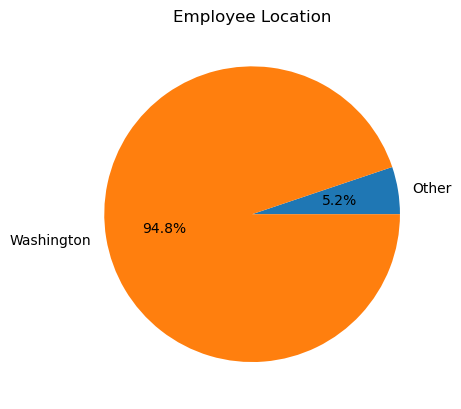

In [518]:
#CirkelDiagram?
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot some data on the axis
df.loc[df['nbr_of_employees_in_state'] < df['nbr_of_employees_in_state'].sum() * 0.01, 'Name'] = 'Other'

# Gruppera efter 'index' och summera 'values'
df = df.groupby('Name')['nbr_of_employees_in_state'].sum()



ax.pie(df, labels=df.index, autopct='%1.1f%%')

# Set the title and axis labels
ax.set_title('Employee Location')

# Show the plot
plt.show()

Försäljningsdata

In [16]:
# Vilken kund köper mest
best_customers = '''
SELECT 
	CustomerID,
	SUM(SubTotal) AS TotalAmountSpent,
    (SELECT 
        AVG(SubTotal)
    FROM
        Sales.SalesOrderHeader) AS avg_amount_spent
FROM 
	Sales.SalesOrderHeader
GROUP BY
	CustomerID
ORDER BY
    TotalAmountSpent DESC
'''
df = pd.read_sql(sql=best_customers, con=connection)

In [17]:
df.head()

,CustomerID,TotalAmountSpent,avg_amount_spent
0,29818,877107.1923,3491.0656
1,29715,853849.1795,3491.0656
2,29722,841908.7707,3491.0656
3,30117,816755.5763,3491.0656
4,29614,799277.8950,3491.0656


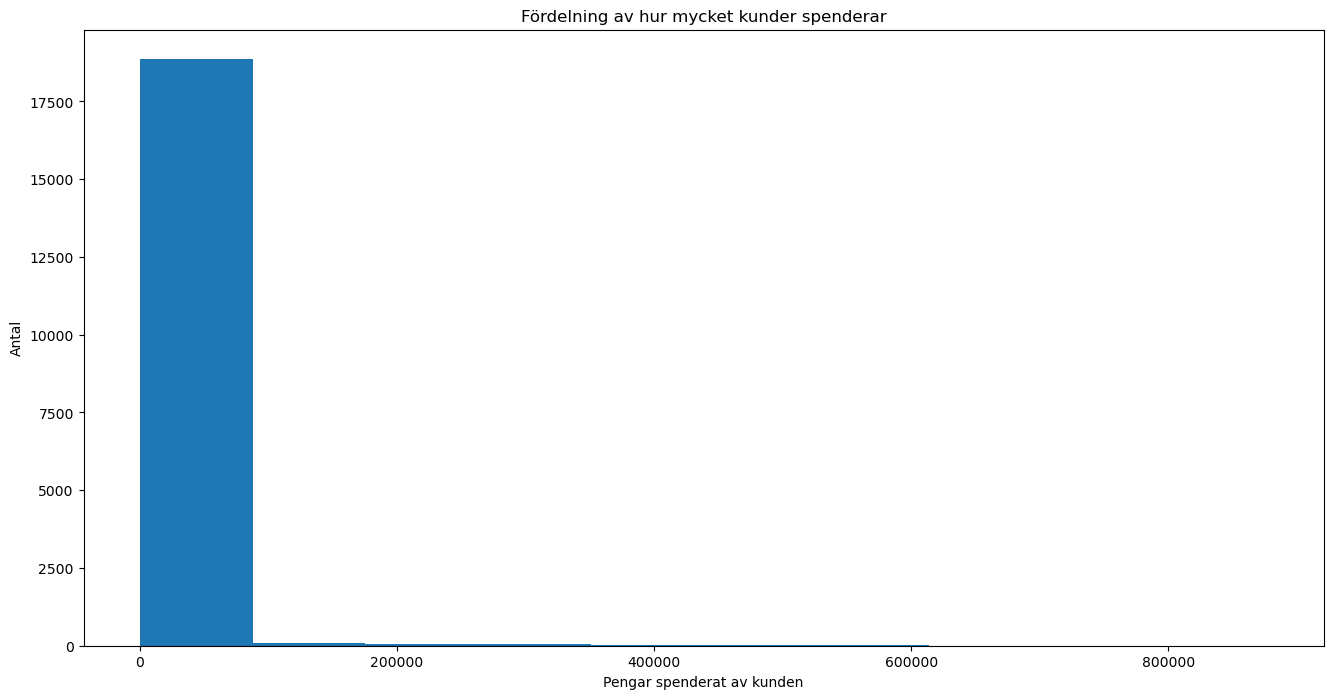

In [18]:
#Diagram
#StapelDiagram 
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(16,8))

# Plot some data on the axis
x = df['CustomerID']
y = df['TotalAmountSpent']
ax.hist(y)

# Set the title and axis labels
ax.set_title('Fördelning av hur mycket kunder spenderar')
ax.set_ylabel('Antal')
ax.set_xlabel('Pengar spenderat av kunden')

# Show the plot
plt.show()

In [524]:
#TOP ratet product 
best_product = '''
SELECT 
    TOP(5) *
FROM 
    Production.ProductReview
ORDER BY 
    Rating Desc
'''
df = pd.read_sql(sql=best_product, con=connection)

In [525]:
df.head()

,ProductReviewID,ProductID,ReviewerName,ReviewDate,EmailAddress,Rating,Comments,ModifiedDate
0,4,798,Laura Norman,2013-11-15,laura@treyresearch.net,5,The Road-550-W from Adventure Works Cycles is ...,2013-11-15
1,1,709,John Smith,2013-09-18,john@fourthcoffee.com,5,I can't believe I'm singing the praises of a p...,2013-09-18
2,2,937,David,2013-11-13,david@graphicdesigninstitute.com,4,"A little on the heavy side, but overall the en...",2013-11-13
3,3,937,Jill,2013-11-15,jill@margiestravel.com,2,Maybe it's just because I'm new to mountain bi...,2013-11-15


In [24]:
# Most sold item
most_sold_item = '''
SELECT 
    ProductID,
    SUM(OrderQty) AS Total_amount_sold,
    SUM(LineTotal) AS Total_price
FROM 
    Sales.SalesOrderDetail
GROUP BY 
    ProductID
ORDER BY 
    Total_price DESC
'''
df = pd.read_sql(sql=most_sold_item, con=connection)

In [25]:
df.head()

,ProductID,Total_amount_sold,Total_price
0,782,2977,4.400593e+06
1,783,2664,4.009495e+06
2,779,2394,3.693678e+06
3,780,2234,3.438479e+06
4,781,2216,3.434257e+06


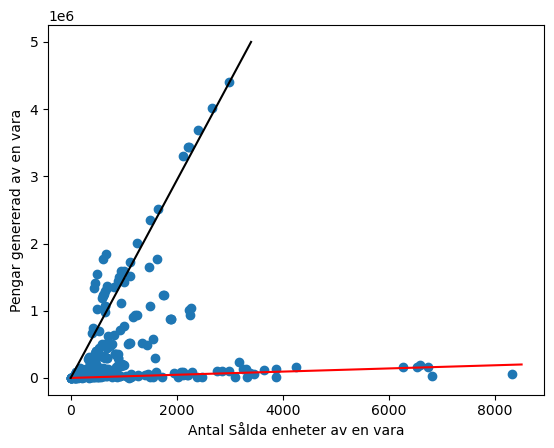

In [21]:
#Diagram
#Diagram
#StapelDiagram 
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot some data on the axis
x = df['Total_amount_sold']
y = df['Total_price']
ax.scatter(x, y)

# Set the title and axis labels
ax.set_title('')
ax.set_xlabel('Antal Sålda enheter av en vara')
ax.set_ylabel('Pengar genererad av en vara')

# Show the plot
plt.plot([0, 8500], [0, 200000], color='red')
plt.plot([0, 3400], [0, 5000000], color='black')
plt.show()

In [529]:
#Korrelations Koeficcient
corr_coef = np.corrcoef(x, y)[0, 1]

# Print the result
print(f"The correlation coefficient between x and y is {corr_coef:.2f}.")

The correlation coefficient between x and y is 0.15.


In [598]:
#Most Money goten from a product
most_valuebal_item = '''
SELECT 
    ProductID,
    SUM(OrderQty) AS Total_amount_sold,
    SUM(LineTotal) AS Total_price
FROM 
    Sales.SalesOrderDetail
GROUP BY 
    ProductID
ORDER BY
    Total_price DESC
'''
df = pd.read_sql(sql=most_valuebal_item, con=connection)

In [599]:
df.head()

,ProductID,Total_amount_sold,Total_price
0,782,2977,4.400593e+06
1,783,2664,4.009495e+06
2,779,2394,3.693678e+06
3,780,2234,3.438479e+06
4,781,2216,3.434257e+06


In [600]:
#Utveckling i pris diagram

In [601]:
#populäraste månaden 
amount_of_orders_per_month = '''
SELECT 
    DATENAME(month, A.OrderDate) AS OrderMonth,
    COUNT(DISTINCT A.SalesOrderID) AS number_of_orders,
    SUM(B.OrderQty) AS Total_amount,
    SUM(B.LineTotal) AS Total_Price
FROM 
    Sales.SalesOrderHeader AS A
INNER JOIN 
    Sales.SalesOrderDetail AS B
    ON A.SalesOrderID = B.SalesOrderID
WHERE 
    OrderDate 
BETWEEN 
    '2011-05-31 00:00:00.000' AND '2014-05-31 00:00:00.000'
GROUP BY 
    DATENAME(month, OrderDate)
ORDER BY 
    Total_Price	 DESC'''
df = pd.read_sql(sql=amount_of_orders_per_month, con=connection)

In [602]:
df.head(12)

,OrderMonth,number_of_orders,Total_amount,Total_Price
0,March,3144,34016,1.360535e+07
1,May,3175,34692,1.219071e+07
2,October,2616,26915,1.192867e+07
3,July,2356,29940,1.035891e+07
4,January,2877,19584,1.034832e+07
5,June,1250,28047,9.639334e+06
6,September,2300,23027,8.489134e+06
7,December,2656,17494,8.214755e+06
8,August,2324,20019,8.005418e+06
9,April,2812,14167,5.964041e+06


In [603]:
#statistisk dataanalys
# Beräkna konfidensintervallet för medelvärdet av priset på produkterna
n = len(df)
mean_price = df['Total_Price'].mean()
std_price = df['Total_Price'].std()
alpha = 0.05
t_value = t.ppf(1 - alpha / 2, n - 1)
margin_of_error = t_value * std_price / np.sqrt(n)
lower_bound = mean_price - margin_of_error
upper_bound = mean_price + margin_of_error

# Skriv ut resultatet
print(f"Konfidensintervallet för medelvärdet av priset på produkterna är ({lower_bound:.2f}, {mean_price:.2f}, {upper_bound:.2f}) dollar.")

Konfidensintervallet för medelvärdet av priset på produkterna är (7443816.98, 9149781.30, 10855745.61) dollar.


In [604]:
#statistisk dataanalys
# Beräkna konfidensintervallet för medelvärdet av priset på produkterna
n = len(df)
mean_price = df['Total_amount'].mean()
std_price = df['Total_amount'].std()
alpha = 0.05
t_value = t.ppf(1 - alpha / 2, n - 1)
margin_of_error = t_value * std_price / np.sqrt(n)
lower_bound = mean_price - margin_of_error
upper_bound = mean_price + margin_of_error

# Skriv ut resultatet
print(f"Konfidensintervallet för medelvärdet av priset på produkterna är ({lower_bound:.2f}, {mean_price:.2f}, {upper_bound:.2f}) dollar.")

Konfidensintervallet för medelvärdet av priset på produkterna är (17662.53, 22732.00, 27801.47) dollar.


In [605]:
#statistisk dataanalys
# Beräkna konfidensintervallet för medelvärdet av priset på produkterna
n = len(df)
mean_price = df['number_of_orders'].mean()
std_price = df['number_of_orders'].std()
alpha = 0.05
t_value = t.ppf(1 - alpha / 2, n - 1)
margin_of_error = t_value * std_price / np.sqrt(n)
lower_bound = mean_price - margin_of_error
upper_bound = mean_price + margin_of_error

# Skriv ut resultatet
print(f"Konfidensintervallet för medelvärdet av priset på produkterna är ({lower_bound:.2f}, {mean_price:.2f}, {upper_bound:.2f}) dollar.")

Konfidensintervallet för medelvärdet av priset på produkterna är (2219.55, 2543.83, 2868.12) dollar.


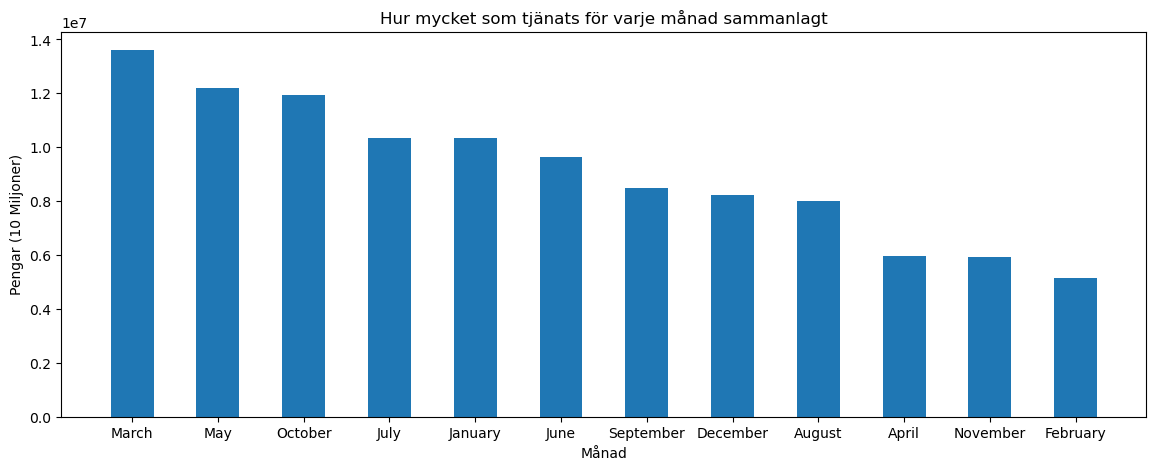

In [540]:
#Stapel
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(14,5))

# Plot some data on the axis
x = df['OrderMonth']
y = df['Total_Price']
ax.bar(x, y, width=0.5)

# Set the title and axis labels
ax.set_title('Hur mycket som tjänats för varje månad sammanlagt')
ax.set_xlabel('Månad')
ax.set_ylabel('Pengar (10 Miljoner)')

# Show the plot
plt.show()

In [247]:
#Korrelations koefficiengt

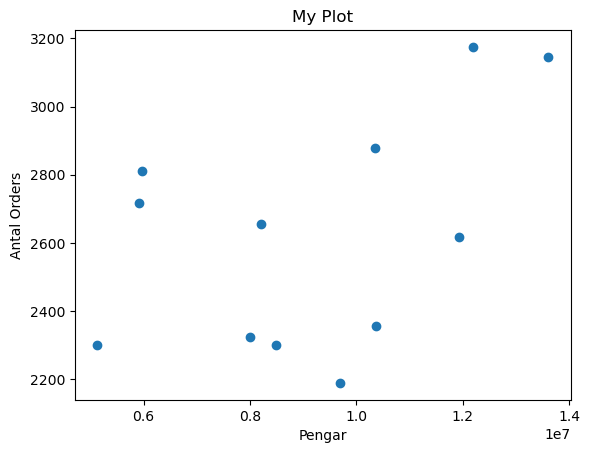

In [255]:
#Stapel
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot some data on the axis
x = df['Total_Price']
y = df['number_of_orders']
ax.scatter(x, y)

# Set the title and axis labels
ax.set_title('My Plot')
ax.set_xlabel('Pengar')
ax.set_ylabel('Antal Orders')

# Show the plot
plt.show()

In [256]:
#Korrelations Koeficcient
corr_coef = np.corrcoef(x, y)[0, 1]

# Print the result
print(f"The correlation coefficient between x and y is {corr_coef:.2f}.")

The correlation coefficient between x and y is 0.47.


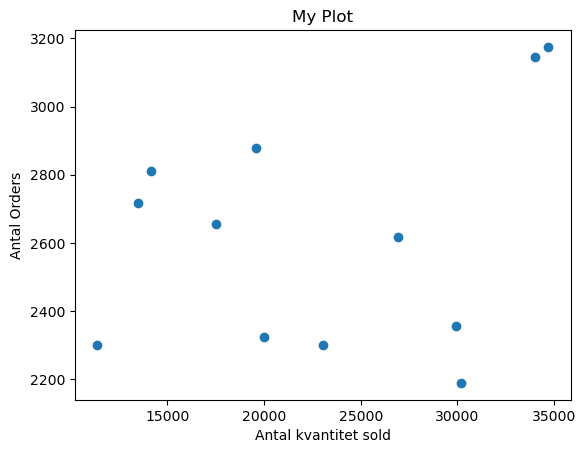

In [257]:
#Stapel
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot some data on the axis
x = df['Total_amount']
y = df['number_of_orders']
ax.scatter(x, y)

# Set the title and axis labels
ax.set_title('My Plot')
ax.set_xlabel('Antal kvantitet sold')
ax.set_ylabel('Antal Orders')

# Show the plot
plt.show()

In [258]:
#Korrelations Koeficcient
corr_coef = np.corrcoef(x, y)[0, 1]

# Print the result
print(f"The correlation coefficient between x and y is {corr_coef:.2f}.")

The correlation coefficient between x and y is 0.27.


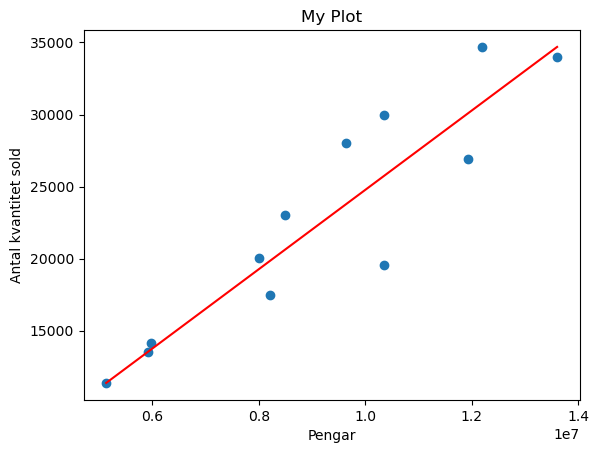

In [581]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot some data on the axis
x = df['Total_Price']
y = df['Total_amount']
ax.scatter(x, y)

# Set the title and axis labels
ax.set_title('Korrelationen mellan vinst och såld kvantitet')
ax.set_xlabel('Pengar')
ax.set_ylabel('Antal kvantitet sold')

# Show the plot
plt.plot([x.min(), x.max()], [y.min(), y.max()], color='red')
plt.show()

In [260]:
#Korrelations Koeficcient
corr_coef = np.corrcoef(x, y)[0, 1]

# Print the result
print(f"The correlation coefficient between x and y is {corr_coef:.2f}.")

The correlation coefficient between x and y is 0.91.


In [22]:
#Vilken product som är populärast för varje månad
monthly_product = '''
WITH MonthlyOrders AS (
    SELECT 
        DATENAME(month, A.OrderDate) AS OrderMonth,
        B.ProductID,
        COUNT(*) AS NumberOfOrders,
        SUM(B.LineTotal) AS Total_money_made,
        SUM(B.OrderQty) AS Total_sold_quantity
    FROM 
        Sales.SalesOrderHeader AS A
    INNER JOIN 
        Sales.SalesOrderDetail AS B
        ON A.SalesOrderID = B.SalesOrderID
    GROUP BY 
        DATENAME(month, A.OrderDate),
        B.ProductID
),
Rankings AS (
    SELECT 
        OrderMonth,
        ProductID,
        Total_sold_quantity,
        NumberOfOrders,
        Total_money_made,
        ROW_NUMBER() OVER(PARTITION BY OrderMonth ORDER BY Total_money_made DESC) as Rank
    FROM 
        MonthlyOrders
)
SELECT 
    OrderMonth,
    ProductID,
    Total_sold_quantity,
    Total_money_made,
    NumberOfOrders
FROM 
    Rankings
WHERE 
    Rank = 1
ORDER BY
    Total_money_made DESC;'''
df = pd.read_sql(sql=monthly_product, con=connection)

In [23]:
df.head(12)

,OrderMonth,ProductID,Total_sold_quantity,Total_money_made,NumberOfOrders
0,March,782,360,525328.321792,146
1,May,782,336,508536.995700,135
2,June,782,320,449951.801260,111
3,September,782,301,416856.242025,102
4,July,782,294,398670.284347,81
5,December,782,262,388771.302400,121
6,January,782,243,378514.927776,126
7,October,783,251,375394.790100,108
8,November,783,174,284577.315492,94
9,April,782,170,283267.334100,105


In [291]:
#statistisk dataanalys
# Beräkna konfidensintervallet för medelvärdet av priset på produkterna
n = len(df)
mean_price = df['NumberOfOrders'].mean()
std_price = df['NumberOfOrders'].std()
alpha = 0.05
t_value = t.ppf(1 - alpha / 2, n - 1)
margin_of_error = t_value * std_price / np.sqrt(n)
lower_bound = mean_price - margin_of_error
upper_bound = mean_price + margin_of_error

# Skriv ut resultatet
print(f"Konfidensintervallet för medelvärdet av priset på produkterna är ({lower_bound:.2f}, {mean_price:.2f}, {upper_bound:.2f}) dollar.")

Konfidensintervallet för medelvärdet av priset på produkterna är (354.98, 390.67, 426.35) dollar.


Slut på försäljningsdata

In [542]:
# Top 5 säljarna
best_sellers = '''
SELECT 
	BusinessEntityID,
	SalesQuota,
	SUM(SalesYTD + SalesLastYear) AS SalesLastYTD
FROM 
    Sales.SalesPerson
WHERE 
    SalesQuota IS NOT NULL
GROUP BY 
    BusinessEntityID, SalesQuota
ORDER BY 
    SalesLastYTD DESC
'''
df = pd.read_sql(sql=best_sellers, con=connection)

In [543]:
df.head()

,BusinessEntityID,SalesQuota,SalesLastYTD
0,289,250000.0,5.752695e+06
1,276,250000.0,5.690525e+06
2,290,250000.0,5.518156e+06
3,275,300000.0,5.513585e+06
4,277,250000.0,5.186605e+06


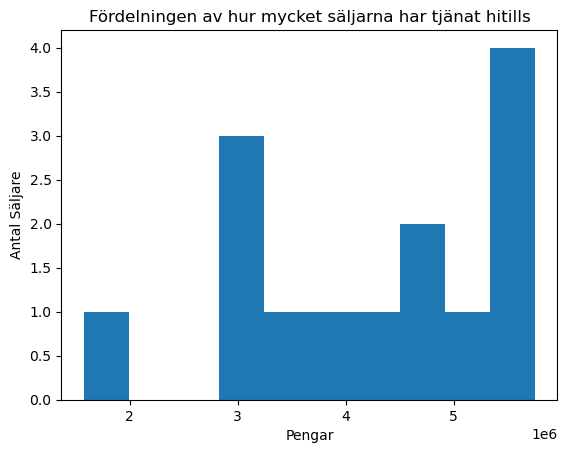

In [544]:
#Diagram
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot some data on the axis
x = df['SalesLastYTD']
y = df['BusinessEntityID']
ax.hist(x)

# Set the title and axis labels
ax.set_title('Fördelningen av hur mycket säljarna har tjänat hitills')
ax.set_xlabel('Pengar')
ax.set_ylabel('Antal Säljare')

# Show the plot
plt.show()

In [545]:
#Avdelning med bäst lön
best_paying_department = '''
WITH CTE_EmployeeRate
AS (
	SELECT 
		B.BusinessEntityID,
		MAX(B.Rate) AS MaxRate
	FROM 
		HumanResources.EmployeeDepartmentHistory A
	INNER JOIN 
		HumanResources.EmployeePayHistory B
		ON A.BusinessEntityID = B.BusinessEntityID
	WHERE 
		A.EndDate IS NULL
	GROUP BY 
		B.BusinessEntityID
)

SELECT
    AVG(MaxRate) AS AveragePayRate,
	C.Name
FROM 
    CTE_EmployeeRate A
INNER JOIN 
    HumanResources.EmployeeDepartmentHistory B
	ON A.BusinessEntityID = B.BusinessEntityID
INNER JOIN 
    HumanResources.Department C
	ON B.DepartmentID = C.DepartmentID
GROUP BY 
    C.Name
ORDER BY 
    AveragePayRate '''
df = pd.read_sql(sql=best_paying_department, con=connection)

In [546]:
df.head(16)

,AveragePayRate,Name
0,10.8718,Shipping and Receiving
1,13.0316,Facilities and Maintenance
2,14.1610,Production
3,14.3884,Document Control
4,17.5412,Quality Assurance
5,18.0000,Marketing
6,18.0248,Human Resources
7,18.6794,Production Control
8,19.8017,Purchasing
9,27.1731,Tool Design


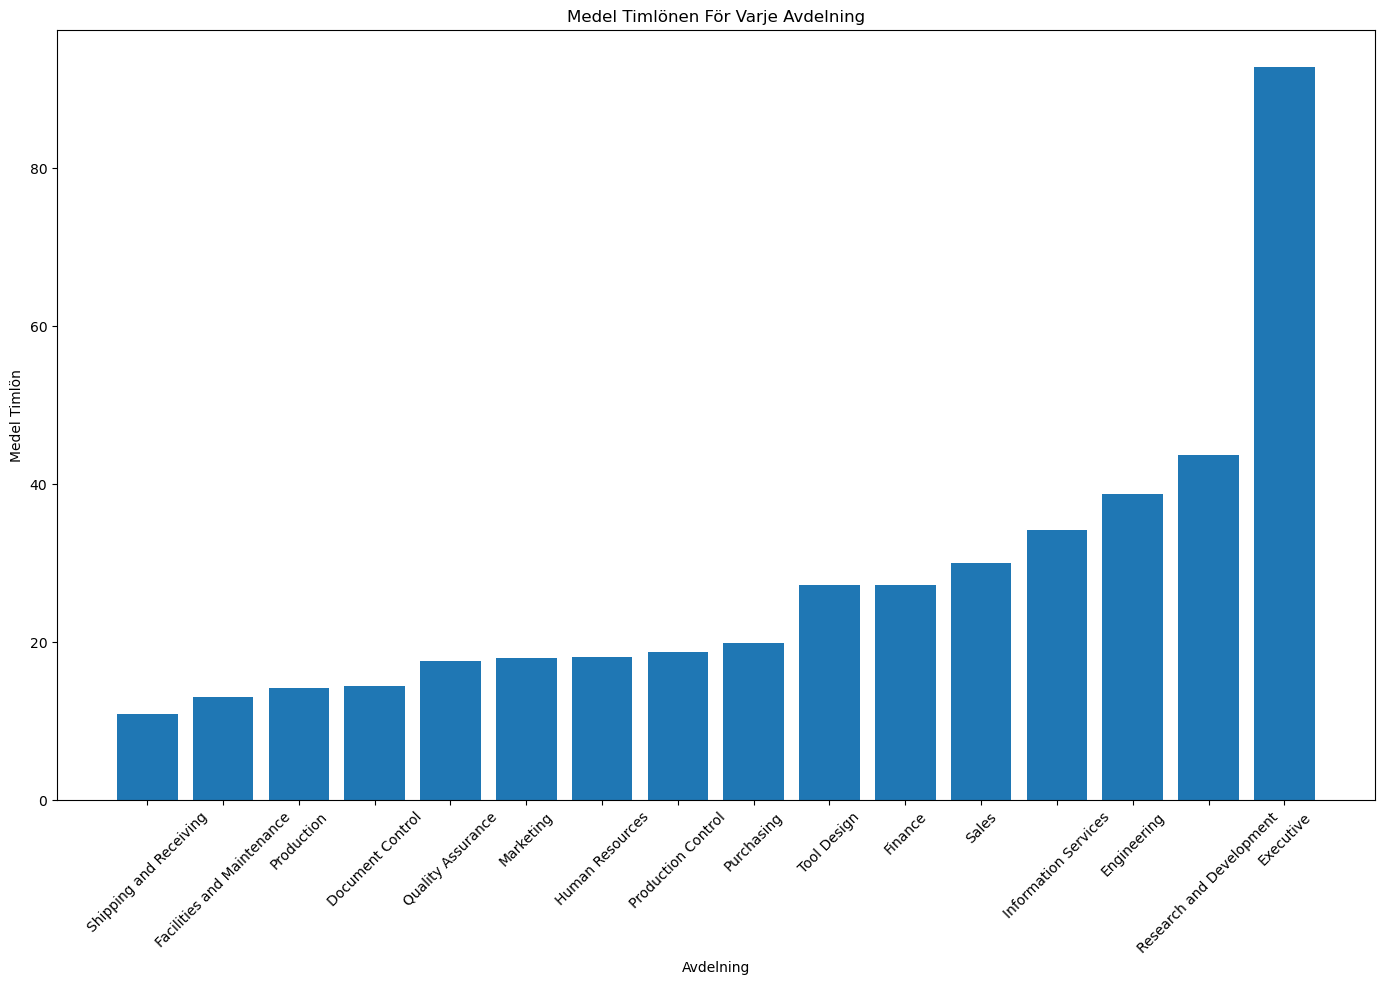

In [547]:
#Diagram
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(17, 10))

# Plot some data on the axis
x = df['AveragePayRate'][0:16]
y = df['Name'][0:16]
ax.bar(y, x)

# Set the title and axis labels
ax.set_title('Medel Timlönen För Varje Avdelning')
ax.set_xlabel('Avdelning')
ax.set_ylabel('Medel Timlön')

# Show the plot
plt.xticks(rotation=45)

plt.show()

In [548]:
#Seller that meed their sales quota (All of them does it)
meet_sales_quota = '''
SELECT TOP(5)
	BusinessEntityID,
	SalesQuota,
	SalesYTD,
	SalesLastYear
FROM 
    Sales.SalesPerson
WHERE 
    SalesQuota > SalesYTD
ORDER BY 
    SalesYTD
'''
df = pd.read_sql(sql=meet_sales_quota, con=connection)

In [549]:
df.head()

,BusinessEntityID,SalesQuota,SalesYTD,SalesLastYear


In [612]:
#Produkter som behöver påfylling
needs_restocking = '''
SELECT A.ProductID,
	SUM(A.Quantity) AS Quantity,
	B.ReorderPoint
FROM 
    Production.ProductInventory A
INNER JOIN 
    Production.Product B
	ON B.ProductID = A.ProductID
GROUP BY 
	A.ProductID, B.ReorderPoint
HAVING
	B.ReorderPoint > SUM(A.Quantity)'''
df = pd.read_sql(sql=needs_restocking, con=connection)

In [613]:
df.head()

,ProductID,Quantity,ReorderPoint
0,386,725,750
1,462,701,750
2,853,0,3
3,859,0,3
4,876,0,3
